In [2]:
"""
This code is used to build sigmoid regression model
Libraries:
pandas
numpy
random
sklearn
scipy
matplotlib
copy
"""
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import copy
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.base import clone
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LogisticRegression

In [3]:
train_data = pd.read_csv("combined_train_with_features.csv")
valid_data = pd.read_csv("combined_valid_with_features.csv")

In [5]:
train_data.shape

(180, 103)

In [6]:
valid_data.shape

(49, 103)

In [7]:
X = train_data['MolLogP'].values
y = train_data['rtmed'].values

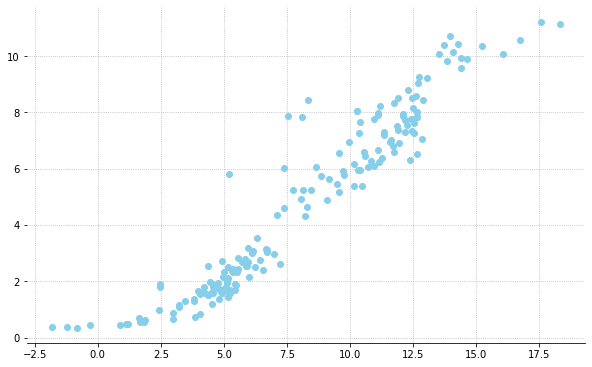

In [8]:
fig, ax = plt.subplots(figsize=(10,6.18))
ax.grid(True, which='major', linestyle=':')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.plot(X, y, 'o', color='skyblue')

In [9]:
def sigmoid(x, L ,x0, k, a, b):
    y = L / (a + np.exp(-k*(x-x0)))+b
    return y

p0 = [max(y), np.median(X),1,1, min(y)] # this is an mandatory initial guess
popt, pcov = curve_fit(sigmoid, X, y, p0)

In [10]:
len(X.reshape(-1,1))

180

In [11]:
X_new = np.linspace(-3,20,180)

In [12]:
X_new = np.linspace(-3,20,180)
y_new = sigmoid(X_new, *popt)

Text(0, 0.5, 'Retention Time (min)')

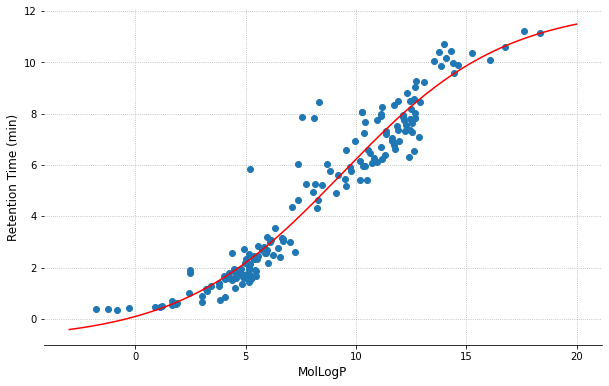

In [13]:
fig, ax = plt.subplots(figsize=(10,6.18))
fig.patch.set_facecolor('white')
ax.grid(True, which='major', linestyle=':')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.plot(X, y, 'o')
ax.plot(X_new, y_new, '-', color='red')

# fig.suptitle("Model Performance vs Training Size", y=0.96, fontsize=14, fontweight='bold')
ax.set_xlabel("MolLogP", fontdict={'fontsize': 12})
ax.set_ylabel("Retention Time (min)", fontdict={'fontsize': 12})

# fig.savefig("fit_sigmoid.png", dpi=300)

In [14]:
y_pred = sigmoid(X, *popt)

Text(0, 0.5, 'Retention Time Residuals')

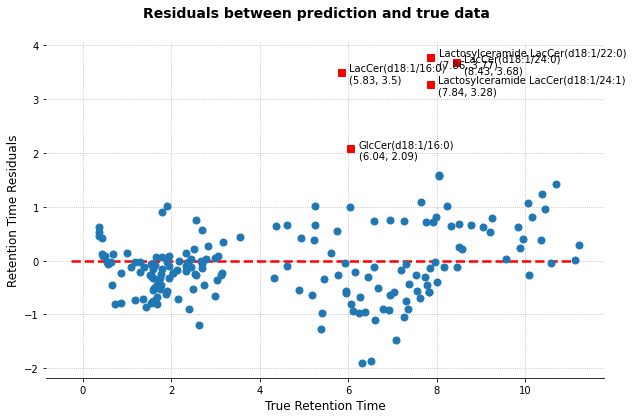

In [15]:
fig, ax = plt.subplots(figsize=(10,6.18))
fig.patch.set_facecolor('white')
ax.grid(True, which='major', linestyle=':')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.plot(y[np.where(abs(y-y_pred)<=2)[0]], (y-y_pred)[np.where(abs(y-y_pred) <= 2)[0]], 'o', markersize=7)
ax.plot(y[np.where(abs(y-y_pred)>2)[0]], (y-y_pred)[np.where(abs(y-y_pred) > 2)[0]], 's', markersize=7, color='r')
ax.hlines(0, min(y_pred), max(y_pred), linewidth=2.5, color='red',linestyles='--')

for i, j in zip(y[np.where(y-y_pred > 2)[0]], (y-y_pred)[np.where(abs(y-y_pred) > 2)[0]]):
    name = train_data[train_data.rtmed==i].metabolite.values[0]
    label = (float("%.2f"%i), float("%.2f"%j))
    ax.annotate(name+'\n'+str(label), (i+0.2,j-0.2))

# ax.plot(X, y, 'o', color='skyblue')
# ax.plot(X_new, y_new, '-', color='red')

fig.suptitle("Residuals between prediction and true data", y=0.96, fontsize=14, fontweight='bold')
ax.set_xlabel("True Retention Time", fontdict={'fontsize': 12})
ax.set_ylabel("Retention Time Residuals", fontdict={'fontsize': 12})

# fig.savefig("outliers_sigmoid.png", dpi=300)

# Cross Validation

In [16]:
def MAE(y, y_pred):
    # y, y_pred are numpy.ndarray
    mae = sum(abs(y-y_pred)) / len(y)
    return mae

In [17]:
def split_data_index(data, K):
    
    index_arr = data.index.values
    shuffle_index_arr = copy.copy(index_arr)
    
#     random.seed(444)
    random.seed(222)
#     random.seed(1)
    shuffle_index_arr = shuffle_index_arr.reshape(-1,K)
    for arr in shuffle_index_arr:
        random.shuffle(arr)
    
    cv_outer = []
    for i in range(K):

        test_index = shuffle_index_arr[:,i]
        train_index = np.delete(shuffle_index_arr, i, axis=1).reshape(1,-1)[0]

        cv_outer.append([train_index, test_index])
    
    return cv_outer

In [18]:
def sigmoid_cv(data, cv_outer):
    
    def sigmoid(x, L ,x0, k, a, b):
        y = L / (a + np.exp(-k*(x-x0)))+b
        return y
    
    MAE_results = []
    RMSE_results = []
    MedAE_results = []
    r2_results = []
    
    X = data['MolLogP'].values
    y = data['rtmed'].values
    for train_index, test_index in cv_outer:

        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        
        p0 = [max(y), np.median(X), 1, 1, min(y)] 
        popt, pcov = curve_fit(sigmoid, X_train, y_train, p0)
        
        y_pred = sigmoid(X_test, *popt)
        
        mae = MAE(y_test, y_pred)
        MAE_results.append(mae)
        
        rmse = mean_squared_error(y_test,y_pred,squared=False)
        RMSE_results.append(rmse)
        
        med = median_absolute_error(y_test, y_pred)
        MedAE_results.append(med)
        
        r2 = r2_score(y_test, y_pred)
        r2_results.append(r2)
        
    
    return MAE_results, RMSE_results, MedAE_results, r2_results

In [19]:
cv_outer = split_data_index(train_data, 10)
MAE_results, RMSE_results, MedAE_results, r2_results = sigmoid_cv(train_data, cv_outer)

In [20]:
MAE_results

[0.9193809206177094,
 0.7609172156529794,
 0.6102577549971806,
 0.5424450187535554,
 0.4347494150288972,
 0.5314813525705229,
 0.43084248928328034,
 0.6142672210551628,
 0.44964614303666395,
 0.44342466862614094]

In [21]:
RMSE_results

[1.4133277639245447,
 1.063798510872314,
 0.7474289035976001,
 0.6905834457245631,
 0.5601930072793538,
 0.6963275087725229,
 0.5469686113313025,
 1.090225737134301,
 0.5329967970550296,
 0.5230715302247827]

In [22]:
np.mean(MAE_results)

0.5737412199622092

In [23]:
np.mean(RMSE_results)

0.7864921815916316

# Test on validation set

In [24]:
def sigmoid(x, L ,x0, k, a, b):
    y = L / (a + np.exp(-k*(x-x0)))+b
    return y

In [25]:
X = train_data['MolLogP'].values
y = train_data['rtmed'].values

In [26]:
X_valid = valid_data['MolLogP'].values
y_valid = valid_data['rtmed'].values

In [27]:
p0 = [max(y), np.median(X), 1, 1, min(y)] 
popt, pcov = curve_fit(sigmoid, X, y, p0)

In [28]:
y_valid_pred = sigmoid(X_valid, *popt)

In [29]:
sigmoid_mae = MAE(y_valid, y_valid_pred)

In [30]:
sigmoid_mae

0.6859269144247635

In [31]:
sigmoid_rmse = mean_squared_error(y_valid, y_valid_pred,squared=False)

In [32]:
sigmoid_rmse

0.840785693075293

In [33]:
sigmoid_med = median_absolute_error(y_valid, y_valid_pred)

In [34]:
sigmoid_med

0.5602824947314131

In [35]:
sigmoid_r2 = r2_score(y_valid, y_valid_pred)

In [36]:
sigmoid_r2

0.8681245072844999

In [37]:
len(y_valid_pred)

49

# Plot between y_true and y_pred

Text(0, 0.5, 'Predicted Retention Time (min)')

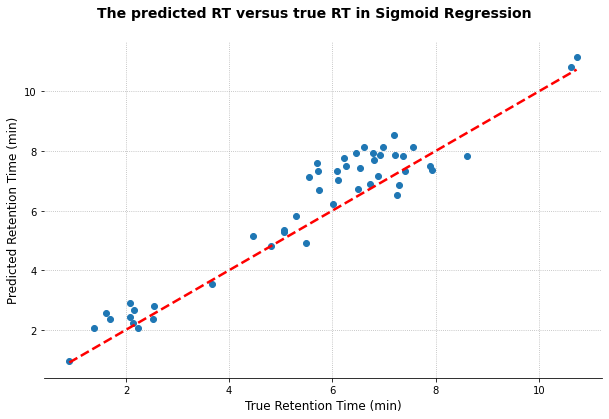

In [38]:
fig, ax = plt.subplots(figsize=(10,6.18))
fig.patch.set_facecolor('white')
ax.grid(True, which='major', linestyle=':')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.plot(y_valid, y_valid_pred, 'o')
ax.plot(y_valid, y_valid, '--', color='red', linewidth=2.5)
# ax.legend()

fig.suptitle("The predicted RT versus true RT in Sigmoid Regression", y=0.96, fontsize=14, fontweight='bold')
ax.set_xlabel("True Retention Time (min)", fontdict={'fontsize': 12})
ax.set_ylabel("Predicted Retention Time (min)", fontdict={'fontsize': 12})

# fig.savefig("Sigmoid_validation_pred_true.png", dpi=300)

In [40]:
pred_df = pd.DataFrame([y_valid,y_valid_pred]).transpose()
pred_df.columns = ['Valid_true', 'Sigmoid_pred']
pred_df.to_csv("Combined_Validation_Predict_Sigmoid.csv", index=False)